In [1]:
%load_ext lab_black
%load_ext autoreload

In [3]:
from pyprojroot import here  # nicked from Simon, cheers man!
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import variation
import scipy.stats as stats

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# from xgboost import XGBClassifier

plt.style.use("seaborn")
plt.style.use("seaborn-poster")

sys.path.append(
    str(here())
)  # adds the project directory to a list of locations the python interpreter searches through when attempting to import modules

# Custom module imports
from src import df_cleaner
from src import plot_functions as pf
from src import plots

raw_data_path = here() / "data" / "abalone.csv"

In [4]:
df = pd.read_csv(raw_data_path)
df = df_cleaner.snake_case(df)
df = pd.get_dummies(df)
df.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


## Making classes for rings

In [5]:
bin_labels = ["1", "2", "3", "4"]
df["quantile"] = pd.qcut(df["rings"], q=4, labels=bin_labels)
df.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M,quantile
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1,4
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0,2
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1,3
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0,1


In [6]:
results, bin_edges = pd.qcut(
    df["rings"], q=[0, 0.25, 0.5, 0.75, 1], labels=bin_labels, retbins=True
)

results_table = pd.DataFrame(zip(bin_edges, bin_labels), columns=["Threshold", "Tier"])
results_table

,Threshold,Tier
0,1.0,1
1,8.0,2
2,9.0,3
3,11.0,4


In [7]:
df["quantile"].value_counts()

1    1407
3    1121
4     960
2     689
Name: quantile, dtype: int64

<AxesSubplot:>

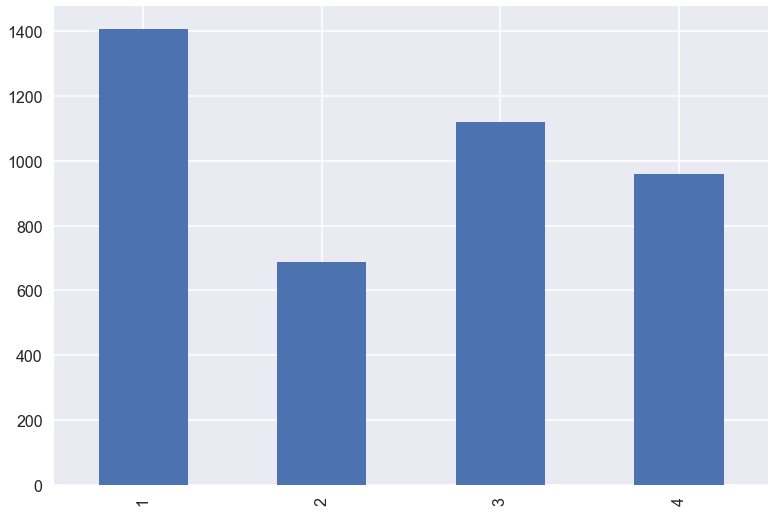

In [8]:
df["quantile"].value_counts().sort_index().plot.bar()

# Predicting Groups

In [9]:
df.head(3)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M,quantile
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,0,1,4
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,0,1,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9,1,0,0,2


In [10]:
target = "quantile"
cols = df.columns.to_list()
features = cols.copy()
features.remove(target)
features.remove("rings")  # as this gives an exact indication of the quantile

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [11]:
model = RandomForestClassifier()

In [12]:
def cross_val(model_name, model, X_train, y_train, cv):
    """Cross validate a model and gives scores and average score

    Keyword arguments:
    model_name -- string of the name, for printing out
    model -- model i.e. xgb, forest
    X_train -- data to use with no target
    y_train -- target
    cv -- number of cross validations
    """
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(f"{model_name} Scores:")
    for i in scores:
        print(round(i, 2))
    print(f"Average {model_name} score: {round(scores.mean(),2)}")

In [13]:
cross_val("Random Forest", model, X_train, y_train, 4)

Random Forest Scores:
0.57
0.54
0.56
0.56
Average Random Forest score: 0.56


In [14]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [15]:
result_df = X_test.copy()
result_df = result_df.merge(y_test, left_index=True, right_index=True)
result_df["Predicted Values"] = preds

In [16]:
result_df

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M,quantile,Predicted Values
866,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.3250,0,0,1,2,4
1483,0.590,0.440,0.150,0.8725,0.3870,0.2150,0.2450,0,0,1,1,1
599,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.3350,1,0,0,4,4
1702,0.635,0.490,0.170,1.2615,0.5385,0.2665,0.3800,1,0,0,2,3
670,0.475,0.385,0.145,0.6175,0.2350,0.1080,0.2150,0,0,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
601,0.385,0.315,0.110,0.2860,0.1225,0.0635,0.0835,1,0,0,3,1
233,0.275,0.215,0.075,0.1155,0.0485,0.0290,0.0350,0,1,0,1,1
2644,0.490,0.375,0.125,0.5445,0.2790,0.1150,0.1300,0,1,0,1,1
931,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,1,0,0,1,1


## GridSearch

In [17]:
def gridsearch(X, y, model, grid, cv):
    """Gridsearch function to perform a gridsearch with different models
    And then return the best parameters for use

    Keyword arguments:
    model -- model to use i.e. XGB
    grid -- dictionary of parameters to try out
    cv -- size of cross validation
    """
    CV = GridSearchCV(estimator=model, param_grid=grid, cv=cv)
    CV.fit(X, y)
    print(CV.best_params_)
    print("Best parameters returned for use")
    return CV.best_params_

### Turning this cell into markdown so it doesn't run every time as it took forever
### Values returned: 
{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

param_grid = {
    "n_estimators": [200, 500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}

# Run the function
forest_params = gridsearch(X, y, model, param_grid, 5)

In [40]:
forest_params

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [43]:
model_optimised = RandomForestClassifier(
    criterion="entropy", max_depth=8, max_features="sqrt", n_estimators=200
)

In [44]:
cross_val(
    model_name="Random Forest",
    model=model_optimised,
    X_train=X_train,
    y_train=y_train,
    cv=4,
)

Random Forest Scores:
0.61
0.58
0.59
0.59
Average Random Forest score: 0.59


In [45]:
model_optimised.fit(X_train, y_train)
preds = model.predict(X_test)

In [46]:
result_df = X_test.copy()
result_df = result_df.merge(y_test, left_index=True, right_index=True)
result_df["Predicted Values"] = preds

In [47]:
result_df

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M,quantile,Predicted Values
866,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.3250,0,0,1,2,4
1483,0.590,0.440,0.150,0.8725,0.3870,0.2150,0.2450,0,0,1,1,1
599,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.3350,1,0,0,4,4
1702,0.635,0.490,0.170,1.2615,0.5385,0.2665,0.3800,1,0,0,2,3
670,0.475,0.385,0.145,0.6175,0.2350,0.1080,0.2150,0,0,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
601,0.385,0.315,0.110,0.2860,0.1225,0.0635,0.0835,1,0,0,3,1
233,0.275,0.215,0.075,0.1155,0.0485,0.0290,0.0350,0,1,0,1,1
2644,0.490,0.375,0.125,0.5445,0.2790,0.1150,0.1300,0,1,0,1,1
931,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,1,0,0,1,1
